### Packages and dataset

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew,boxcox,yeojohnson
#%conda install -c conda-forge bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import roc_auc_score,roc_curve, auc,precision_score,recall_score, precision_recall_curve,plot_precision_recall_curve,accuracy_score,plot_confusion_matrix,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [10]:
#Reading csv
df = pd.read_csv("bank_marketing_weka_dataset.csv")

#Separate features
X = df.drop(['y'], axis=1)

#Target variable
y = df['y']

#Transform 'y' to binary
y = y.map(dict(yes=1, no=0))

#Continuos variables
conti = X.select_dtypes(include=np.number)

In [11]:
#Features initial state
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199.0,4,-1.0,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226.0,1,-1.0,0,unknown


## Target variable balance

In [12]:
y.value_counts()

0    4000
1     521
Name: y, dtype: int64

# Features engineering

## Modifications for the whole dataset

### Binary values
Variables: 'default', 'housing', 'loan'\
Values: 'yes', 'no'\
Method: map to yes=1, no=0

In [13]:
X = X.replace('yes', 1)
X = X.replace('no', 0)

### Month variable
Values: string abbreviations\
Method: transform to numerical

In [14]:
X.month = X.month.map(dict(
jan=1, feb=2, mar=3, apr=4, may=5, jun=6,
jul=7, aug=8, sep=9, oct=10, nov=11, dec=12))

## Train test split
Now we split the dataset to train and test parts to prevent data leakage in the future model leaning.

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42,stratify=y)

## Continuous variables

### Train set

In [16]:
def skew(X, conti):
    '''Calculates skewness of continuous variables in dataset. conti - var list
    returns columns with skewness>2'''
    skewed = []
    for column in conti.columns:
        if conti[column].skew()>2:
            skewed.append(column)
        print(f'{column.capitalize()} skew = {conti[column].skew()}')
    return(skewed)

In [17]:
skew_train = skew(X_train, conti)

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


It is known that ML algorithms tend to perform worse if they have to deal with skewed data. Here we arbitrally have chosen columns with skewness above 2 and transform them, to reduce that parameter.

In [18]:
def skew_reduce(X, skewed):
    '''Applies boxcox or yeojohnson transform on skew vars'''
    for column in skewed:
        if X[column].min()>0:
            print(pd.Series(boxcox(X[column])[0]).skew(),f'{column} boxcox')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(boxcox(X[column])[0])
        else:
            print(pd.Series(yeojohnson(X[column])[0]).skew(),f'{column} yeojohnson')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(yeojohnson(X[column])[0])

Ideally we would like to use boxcox transormation for all our chosen data, but this type of transormation does not work with negative values. Instead of trying to add some constant to these columns with non-positive values we decided to use yeojohnson transormation which is capable of dealing with negative data. As we can see in all of our columns we have managed to reduce skewness massively.

In [19]:
skew_reduce(X_train, skew_train)

1.1399111072539496 balance yeojohnson
0.015517773448774247 duration boxcox
0.16697552573629013 campaign boxcox
1.626877725736565 pdays yeojohnson
1.626167933357519 previous yeojohnson


/home/arctickey/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Test set

In [20]:
skew_test = skew(X_test, conti)

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


In [21]:
skew_reduce(X_test, skew_test)

2.5836387077116316 balance yeojohnson
0.01596915036078293 duration boxcox
0.15796010842169095 campaign boxcox
1.8338049803324448 pdays yeojohnson
1.83514156813807 previous yeojohnson


## Categorical variables

In [22]:
#List of categorical variables
X.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'contact', 'poutcome'], dtype='object')

### Variables: 'job', 'marital', 'education', 'poutcom', 'contact'

Thanks to EDA we know that:

- 'unknown' values are present
- 'job', 'education', 'poutcom' seem to have impact on target variable
- values distributions have no dangerous disparities (in terms of using the target encoding method)

Hence, we decide to:

 - leave the 'unknown' values, as it represents best the idea of the missing information in our case
 - apply target encoding method to variables related with target variable
 - apply one-hot encoding to other variables
 
Expecting target encoding to reflect the relationship of variables with target variable - where it is present according to EDA - and one-hot method to neutrally pass on values of other variables.\
\
For second approach to compere results we decide to apply target encoding for all of these features.

In [23]:
#Approach 1
X1_train = X_train.copy()
X1_test = X_test.copy()

#Target encoding train set
te = TargetEncoder()
X1_train.loc[:, ['job', 'education', 'poutcome']] = te.fit_transform(X1_train.loc[:, ['job', 'education', 'poutcome']], y_train)
#test set
X1_test.loc[:, ['job', 'education', 'poutcome']] = te.transform(X1_test.loc[:, ['job', 'education', 'poutcome']])

#One-hot encoding
X1_train = pd.get_dummies(X1_train, columns=['marital', 'contact'])
X1_test = pd.get_dummies(X1_test, columns=['marital', 'contact'])

#For future
cols = X1_train.columns

Scaling the data just for sake we might use alghoritm that require standarized input.

In [24]:
scaler = StandardScaler()
scaler2 = StandardScaler()

X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)



# Modeling

In [58]:
def modeling(X_train, y_train):
        #cv folds,
        kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        scoring = {'precision': 'precision_macro',
                   'recall': 'recall_macro',
                   'accuracy': 'accuracy',
                   'auc': 'roc_auc'}
        #Logistic regression"
        logistic =  LogisticRegression(C=0.001,solver='saga',random_state=42)
        r_log = cross_validate(logistic,X_train,y_train,scoring=scoring, cv=kfold)
        #xgb
        params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8,'n_estimators':400,'random_state':42}
        xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
        r_xgb = cross_validate(xg, X_train, y_train, cv=kfold, scoring=scoring)
        #random forest
        params = {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500,'max_features':'auto','random_state':42}
        tree = RandomForestClassifier(**params)
        r_ranforest = cross_validate(tree,X_train,y_train,scoring=scoring,cv=kfold)
    
        svm = SVC(C=10)
        r_svm = cross_validate(svm,X_train,y_train,scoring=scoring,cv=kfold)
        return([r_log, r_ranforest, r_xgb,r_svm])

In [59]:
result = modeling(X1_train,y_train)

/home/arctickey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arctickey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arctickey/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arctickey/anaconda3/lib/python3.7/site-packages/sklearn

# Validation scores

Scores means from cross-validation are presented below for three tested algorithms and two features engineering approaches. We observe satisfying accuracy and auc, but recall needs to be improved in future. Its low score is propably caused by imbalance in target variable. Algorithms results are suprisingly very similar. XGBoost performed best in recall score.

In [64]:
r1 = pd.DataFrame(result[0]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("Logistic regression:")
r

Logistic regression:


,X1
validate_precision,0.442340
validate_recall,0.500000
validate_accuarcy,0.884681
validate_auc,0.859009


In [63]:
r1 = pd.DataFrame(result[1]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("Random forest:")
r

Random forest:


,X1
validate_precision,0.492382
validate_recall,0.500367
validate_accuarcy,0.883574
validate_auc,0.872946


In [65]:
r1 = pd.DataFrame(result[2]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("XGBoost:")
r

XGBoost:


,X1
validate_precision,0.754916
validate_recall,0.675866
validate_accuarcy,0.897952
validate_auc,0.899142


In [66]:
r1 = pd.DataFrame(result[3]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("SVM:")
r

SVM:


,X1
validate_precision,0.720049
validate_recall,0.642229
validate_accuarcy,0.888275
validate_auc,0.851814


## Bayes optimization

We will use Bayes Optimization in order to get as good score as we can. We will focus on xgboost alghoritm

In [72]:
pbounds = {'learning_rate': (0.01, 1.0), 'n_estimators': (100.0, 1000.0), 'max_depth': (4.0,10.0), 'subsample': (0.5, 1.0), 'colsample_bytree': (0.5, 1.0),
    'gamma': (0.0,5.0)}
def xgboost_hyper_param(learning_rate,n_estimators,max_depth,subsample,colsample_bytree,gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    clf = xgb.XGBClassifier(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma)
    return np.mean(cross_val_score(clf, X1_train, y_train, cv=3, scoring='roc_auc'))
optimizer = BayesianOptimization(f=xgboost_hyper_param, pbounds=pbounds, random_state=1)
optimizer.maximize()
print('Final Results')
print(optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8905   |  0.7085   |  3.602    |  0.01011  |  5.814    |  232.1    |  0.5462   |
|  2        |  0.8834   |  0.5931   |  1.728    |  0.4028   |  7.233    |  477.3    |  0.8426   |
|  3        |  0.9037   |  0.6022   |  4.391    |  0.03711  |  8.023    |  475.6    |  0.7793   |
|  4        |  0.8792   |  0.5702   |  0.9905   |  0.8027   |  9.81     |  382.1    |  0.8462   |
|  5        |  0.9048   |  0.9382   |  4.473    |  0.09419  |  4.234    |  252.8    |  0.9391   |
|  6        |  0.902    |  1.0      |  5.0      |  0.01     |  10.0     |  1e+03    |  0.5      |
|  7        |  0.9011   |  1.0      |  5.0      |  0.01     |  10.0     |  773.3    |  0.5      |
|  8        |  0.8752   |  0.9231   |  4.731    |  0.8683   |  5.227    |  100.4    |  0.8802   |
|  9        |  0.898

# Test dataset performance

In [37]:
def test(X_train,y_train,X_test,y_test):
        #Logistic regression
        logit = LogisticRegression(C=0.01,solver='saga',random_state=42)
        logit.fit(X_train,y_train)
        pred_log = logit.predict(X_test)
        precision_log = precision_score(y_test,pred_log,average='weighted')
        recall_log = recall_score(y_test,pred_log,average='weighted')
        accuracy = accuracy_score(y_test,pred_log)
        log_data = {'precision':precision_log,'recall': recall_log,'accuracy':accuracy}

        #xgb
        params ={'colsample_bytree': 0.6790427788825881, 'gamma': 4.9437121904855585, 'learning_rate': 0.0686118272168518, 'max_depth': 9.907799344685499, 'n_estimators': 456.4887419999514, 'subsample': 0.7791139392047272}
        xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
        xg.fit(X_train,y_train)
        pred_xg = xg.predict(X_test)
        precision_xg = precision_score(y_test,pred_xg,average='weighted')
        recall_xg = recall_score(y_test,pred_xg,average='weighted')
        accuracy = accuracy_score(y_test,pred_xg)
        xg_data = {'precision':precision_xg,'recall': recall_xg,'accuracy':accuracy}
        #random forest
        params = {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000,'max_features':'auto'}
        tree = RandomForestClassifier(**params)
        tree.fit(X_train,y_train)
        pred_tree = tree.predict(X_test)
        precision_tree = precision_score(y_test,pred_tree,average='weighted')
        recall_tree = recall_score(y_test,pred_tree,average='weighted')
        accuracy = accuracy_score(y_test,pred_tree)
        tree_data = {'precision':precision_tree,'recall': recall_tree,'accuracy':accuracy}
        svm = SVC(C=10)
        svm.fit(X_train,y_train)
        pred_svm = svm.predict(X_test)
        precision_svm = precision_score(y_test,pred_svm,average='weighted')
        recall_svm = recall_score(y_test,pred_svm,average='weighted')
        accuracy = accuracy_score(y_test,pred_svm)
        svm_data = {'precision':precision_svm,'recall': recall_svm,'accuracy':accuracy}
        data = pd.DataFrame([log_data,xg_data,tree_data,svm_data])
        data.index = ['logit','xgb','tree','svm']
        return data.transpose()

In [38]:
result = test(X1_train,y_train,X1_test,y_test)
result

,logit,xgb,tree,svm
precision,0.858637,0.868563,0.862179,0.869466
recall,0.888398,0.882873,0.888398,0.886188
accuracy,0.888398,0.882873,0.888398,0.886188


Almost all classifiers achieved quite simmilar scores, which is a bit surprisng.

## Score analysis

For further tests we decided to use only one out of four classifiers we tested before. Our choice is Xgboost, mainly because of the fact that it is widely known for its superiority over other classification alghoritms.

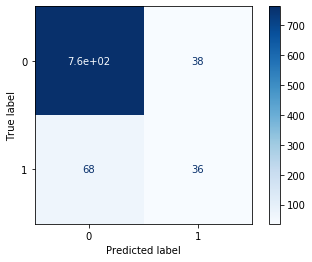

In [40]:
params={'colsample_bytree': 0.6790427788825881, 'gamma': 4.9437121904855585, 'learning_rate': 0.0686118272168518, 'max_depth': 9.907799344685499, 'n_estimators': 456.4887419999514, 'subsample': 0.7791139392047272}
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
xg.fit(X1_train,y_train)
pred_xg = xg.predict(X1_test)
scores = xg.predict_proba(X1_test)[:,1]
plot_confusion_matrix(xg,X1_test,y_test,cmap = plt.cm.Blues)

As we can see our classifier is able to detect one class pretty high, but the detection in the second class is not that great. Fortunately we can easily solve this by varying threshold.

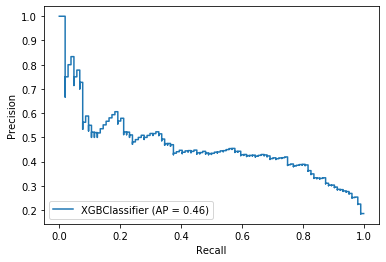

In [41]:
disp = plot_precision_recall_curve(xg, X1_test, y_test)
disp

Average precision score is quite low, but this is because of the fact that we do have an imbalanced data set, so that varying threshold can cause precision to take very low values.

AUC of ROC Curve: 0.8894050705848459


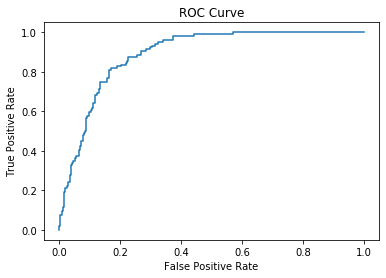

In [44]:
scores = xg.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

ROC curve is among the best tools to determine the performance of classifier working on imbalanced dataset. As we can see our classifier peroform great. It is also worth noting, that if we want to raise precision or recall, we can simply adjust threshold, so that the classifier will fulfill our demands.

In [49]:
decisions = (xg.predict_proba(X1_test) >= 0.1).astype(int)[:,1]
print('Classification Report:\n',classification_report(y_test,decisions))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       801
           1       0.40      0.75      0.53       104

    accuracy                           0.84       905
   macro avg       0.68      0.80      0.72       905
weighted avg       0.90      0.84      0.86       905



Setting threshold for very low value, as we see here 0.1, can easily improve detection on oure second class.

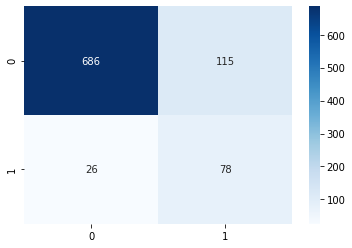

In [71]:
data = confusion_matrix(y_test,decisions)
sns.heatmap(data, cmap="Blues", annot=True,fmt='g')

## Features importances

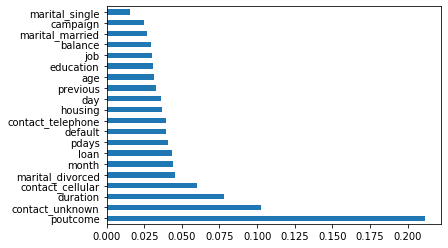

In [50]:

params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8,'n_estimators':1000}
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
xg.fit(X1_train,y_train)
feat_importances = pd.Series(xg.feature_importances_, index=cols)
feat_importances.nlargest(20).plot(kind='barh')

Comparing feature importance scores with our conclusions from EDA, we can see that our predictions turned out to be true. Poutcome column which we assumed to have the biggest impact on predictions, indeed is the most important for our classfier. It makes for over 20% of our prediction which is huge considering the amount of columns that we have. It is also worth joting that contact column make for big part of our prediction, which come as a bit of a surprise, because during EDA we did not suppose, that it will have such a big impact. Fortunately we predicted that duration will have visible impact, but this is quite obvious that longer duration of a call may increase chances of positive outcome